# Assignment02: Applications of CLIP model 

### Basic Imports


### Dataset


In [1]:
import os
from skimage import io
import torchvision.datasets.mnist as mnist

root = "/data/lab/STA303-Assignment02/MNISTdataset"
train_data = mnist.read_image_file(os.path.join(root, 'train-images.idx3-ubyte'))
train_label = mnist.read_label_file(os.path.join(root, 't10k-labels.idx1-ubyte'))
test_data = mnist.read_image_file(os.path.join(root, 't10k-images.idx3-ubyte'))
test_label = mnist.read_label_file(os.path.join(root, 't10k-labels.idx1-ubyte'))

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(train_data[0].size(),train_data.size(),train_label.size(),test_data.size(),test_label.size(),train_data[0])

torch.Size([28, 28]) torch.Size([60000, 28, 28]) torch.Size([10000]) torch.Size([10000, 28, 28]) torch.Size([10000]) tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
         

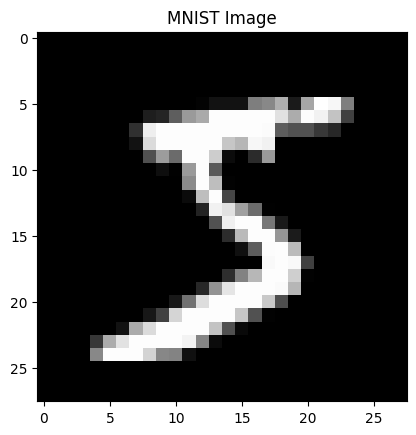

In [3]:
import matplotlib.pyplot as plt
import torchvision.datasets.mnist as mnist

root = "/data/lab/STA303-Assignment02/MNISTdataset"
train_data = mnist.read_image_file(os.path.join(root, 'train-images.idx3-ubyte'))
train_label = mnist.read_label_file(os.path.join(root, 'train-labels.idx1-ubyte'))

# 选择一个图像

image = train_data[0].numpy()

# 显示图像
plt.imshow(image, cmap='gray')
plt.title('MNIST Image')
plt.show()


Train size: torch.Size([28, 28])
Test size: torch.Size([28, 28])


/tmp/ipykernel_254530/1285999361.py:23: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_254530/1285999361.py:23: UserWarning: Glyph 38469 (\N{CJK UNIFIED IDEOGRAPH-9645}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_254530/1285999361.py:23: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_254530/1285999361.py:23: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38469 (\N{CJK UNIFIED IDEOGRAPH-9645}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/pyt

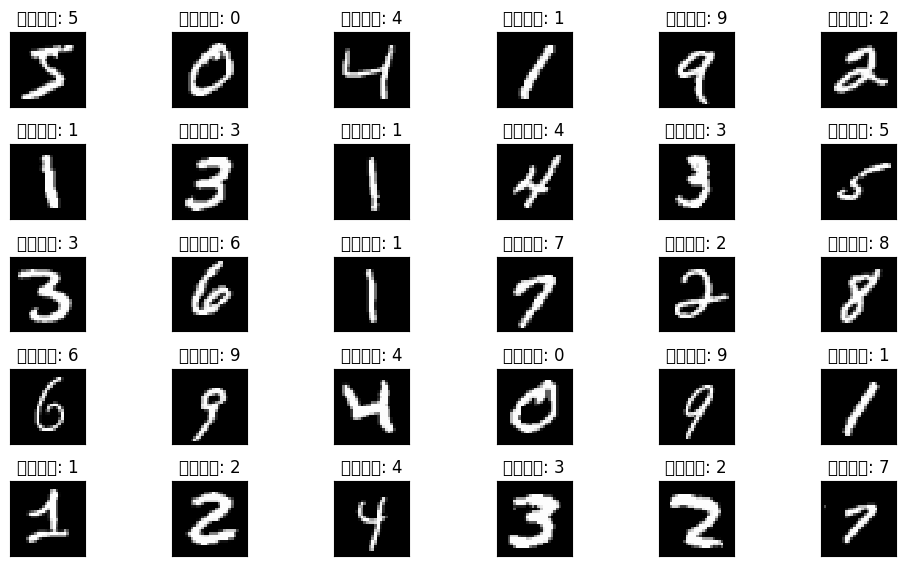

In [4]:
import os
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import torchvision.datasets.mnist as mnist

root = "/data/lab/STA303-Assignment02/MNISTdataset"
train_data = mnist.read_image_file(os.path.join(root, 'train-images.idx3-ubyte'))
train_label = mnist.read_label_file(os.path.join(root, 'train-labels.idx1-ubyte'))
test_data = mnist.read_image_file(os.path.join(root, 't10k-images.idx3-ubyte'))
test_label = mnist.read_label_file(os.path.join(root, 't10k-labels.idx1-ubyte'))
print("Train size:", train_data[0].size())
print("Test size:", test_data[0].size())

np.save('data/train_data.npy', train_data)
np.save('data/train_label.npy', train_label)
np.save('data/test_data.npy', test_data)
np.save('data/test_label.npy', test_label)

fig = plt.figure(figsize=(10, 6))
for i in range(30):
    plt.subplot(5, 6, i + 1)
    plt.tight_layout()
    plt.imshow(train_data[i], cmap='gray', interpolation='none')
    plt.title("实际标签: {}".format(train_label[i]))
    plt.xticks([])
    plt.yticks([])

plt.show()
#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


Train Data
+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
|      #0      |      #1      |      #2      |      #3      |      #4      |      #5      |      #6      |      #7      |      #8      |      #9      |
+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
| tensor(5923) | tensor(6742) | tensor(5958) | tensor(6131) | tensor(5842) | tensor(5421) | tensor(5918) | tensor(6265) | tensor(5851) | tensor(5949) |
+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
Test Data
+-------------+--------------+--------------+--------------+-------------+-------------+-------------+--------------+-------------+--------------+
|      #0     |      #1      |      #2      |      #3      |      #4    

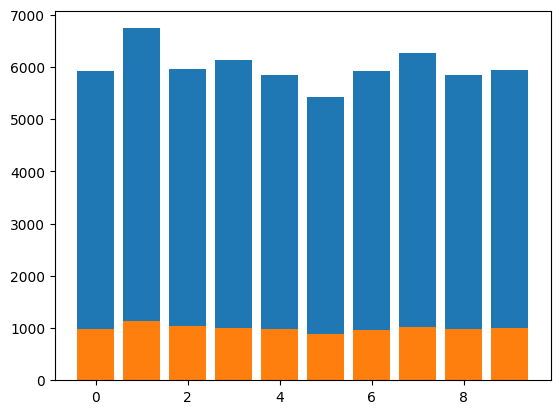

In [5]:
from prettytable import PrettyTable
if __name__ == '__main__':
    print("Train Data")
    b = PrettyTable()
    b.field_names = ["#{}".format(i) for i in range(10)]
    b.add_row([sum(train_label == i) for i in range(10)])
    print(b)

    print("Test Data")
    c = PrettyTable()
    c.field_names = ["#{}".format(i) for i in range(10)]
    c.add_row([sum(test_label == i) for i in range(10)])
    print(c)

    plt.bar([i for i in range(10)], [sum(train_label == i) for i in range(10)])
    plt.bar([i for i in range(10)], [sum(test_label == i) for i in range(10)])
    # plt.plot([sum(train_label == i) for i in range(10)])
    # plt.plot([sum(test_label == i) for i in range(10)])
    plt.show()


In [6]:
import torch
import torchvision
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [7]:
train_dataset = datasets.MNIST(root = '/data/lab/STA303-Assignment02/MNISTdataset', train = True, 
                               transform = transforms.ToTensor(), download = True)
test_dataset = datasets.MNIST(root = '/data/lab/STA303-Assignment02/MNISTdataset', train = False, 
                               transform = transforms.ToTensor(), download = True)

In [8]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 100, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size= 100, shuffle = True)

In [9]:
class Model(torch.nn.Module):
    def __init__(self) :
        super(Model, self).__init__()
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(1, 64, 3, 1, 1),
                                         torch.nn.ReLU(),
                                         torch.nn.Conv2d(64, 128, 3, 1, 1),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d(2, 2)) 
        self.dense = torch.nn.Sequential(torch.nn.Linear(14*14*128, 1024),
                                         torch.nn.ReLU(),
                                         torch.nn.Dropout(p = 0.5),
                                         torch.nn.Linear(1024, 10))
        
    def forward(self, x) :
        x = self.conv1(x)
        x = x.view(-1, 14*14*128)
        x = self.dense(x)
        return x

In [10]:
device = torch.device('cuda')
model = Model().to(device)
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [11]:
if __name__ == "__main__":
    epochs = 5
    for epoch in range(epochs) :
        # train
        sum_loss = 0.0
        train_correct = 0
        for data in train_loader:
            inputs, lables = data
            inputs, lables = Variable(inputs).cuda(), Variable(lables).cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = cost(outputs, lables)
            loss.backward()
            optimizer.step()

            _, id = torch.max(outputs.data, 1)
            sum_loss += loss.data
            train_correct += torch.sum(id == lables.data)

        print('[%d,%d] loss:%.03f' % (epoch + 1, epochs, sum_loss / len(train_loader)))
        print('        correct:%.03f%%' % (100 * train_correct / len(train_dataset)))

[1,5] loss:0.167
        correct:94.897%
[2,5] loss:0.052
        correct:98.438%
[3,5] loss:0.034
        correct:98.950%
[4,5] loss:0.025
        correct:99.203%
[5,5] loss:0.021
        correct:99.317%


In [12]:
model.eval()
test_correct = 0
for data in test_loader:
    inputs, lables = data
    inputs, lables = Variable(inputs).cuda(), Variable(lables).cuda()
    outputs = model(inputs)
    _, id = torch.max(outputs.data, 1)
    test_correct += torch.sum(id == lables.data)
print("correct:%.3f%%" % (100 * test_correct / len(test_dataset)))

correct:98.860%


In [13]:
#pip install ftfy

In [9]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision import datasets
from torchvision import transforms
import torchvision

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from PIL import Image
from clip import clip

In [10]:
# # random seed
# SEED = 1 
# NUM_CLASS = 10

# Training
BATCH_SIZE = 128
# NUM_EPOCHS = 30
# EVAL_INTERVAL=1
# SAVE_DIR = './log'

# # Optimizer
# LEARNING_RATE = 1e-1
# MOMENTUM = 0.9
# STEP=5
# GAMMA=0.5

# CLIP
VISUAL_BACKBONE = 'ViT-B/16' # RN50,ViT-B/32, 


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")


In [12]:
transform_MNIST = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.Grayscale(num_output_channels=3),  # 转换为 RGB
  #  transforms.RandomRotation(1),
    transforms.ToTensor(),
    
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


test_set = torchvision.datasets.MNIST(root='/data/lab/STA303-Assignment02/MNISTdataset', train=False,
                                       download=True, transform=transform_MNIST)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['1', '2', '3', '4', '5', '6', '7', '8','9','0']
dataset_name = 'MNIST'

In [13]:
# Load the model
model, preprocess = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/shareddata/clip/')
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [14]:
def model_inference(model, image):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    model.eval()

    # Move the input data to the device
    image = image.to(device)

    # Forward pass
    with torch.no_grad():
        logits = model(image)
    ###############################################################

    return logits

In [15]:
prompt = "asdqwedqdz@#$$%@"

text_inputs = torch.cat([clip.tokenize(f"{prompt} {c}") for c in class_names]).to(device)

In [16]:
def model_inference(model, image):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    
    image_features = model.encode_image(image)
    text_features = model.encode_text(text_inputs)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    logit_scale = model.logit_scale.exp()

    logits = logit_scale * image_features @ text_features.t()

    ###############################################################

    return logits

In [17]:
labels = ["0", "1", "2", "3", "4", "5","6","7","8","9"]
text_descriptions = [f"A photo of a {label}" for label in labels]
text_tokens = clip.tokenize(text_descriptions).cuda()

# 提取文本特征
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [18]:
testing_loss = []
testing_acc = []

with torch.no_grad():
    model.eval()

    val_loss = 0.0
    val_corrects = 0

    for batch_idx, (image, target) in enumerate(test_dataloader):

        image = image.to(device)
        target = target.to(device)

        # test model
        logits = model_inference(model, image)
        _, preds = torch.max(logits, 1)
        
        val_corrects += torch.sum(preds == target.data)

    val_acc = val_corrects.double() / len(test_set)



    print(f"the zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")

the zero-shot performance on MNIST is 21.77%, visual encoder is ViT-B/16.


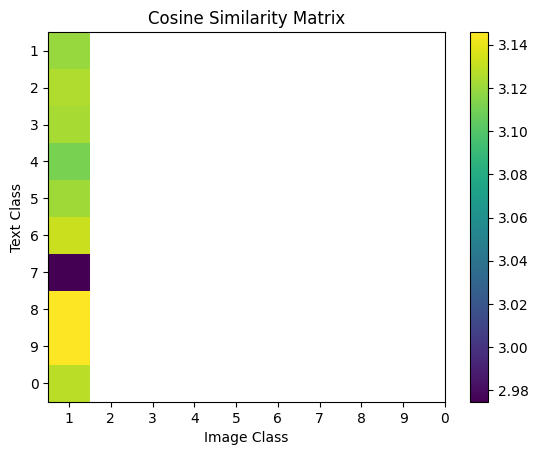

In [20]:
# # 读取图像

# original_images = []
# images = []
# texts = []
# root = "/data/lab/STA303-Assignment02/MNISTdataset"
# # 使用DataLoader加载MNIST数据集中的图像
# sample_batch = next(iter(test_dataloader))
# sample_image, sample_label = sample_batch

# # 使用批次中的第一张图像
# sample_image = sample_image[0].unsqueeze(0).to(device)

# # 对样本图像执行模型推断
# logits = model_inference(model, sample_image)

# # 继续您的代码...

# # 提取图像特征  
# with torch.no_grad():
#     image_features = model.encode_image(logits).float()
#     image_features /= image_features.norm(dim=-1, keepdim=True)

# # 计算余弦相似度（未缩放）
# similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

# 读取图像
original_images = []
images = []
texts = []
root = "/data/lab/STA303-Assignment02/MNISTdataset"
# 使用DataLoader加载MNIST数据集中的图像
sample_batch = next(iter(test_dataloader))
sample_image, sample_label = sample_batch

# 使用批次中的第一张图像
sample_image = sample_image[0].unsqueeze(0).to(device)

# 对样本图像执行模型推断
logits = model_inference(model, sample_image)

# 提取文本特征
text_inputs = torch.cat([clip.tokenize(f"{prompt} {c}") for c in class_names]).to(device)
text_features = model.encode_text(text_inputs)

# 提取图像特征  
with torch.no_grad():
    image_features = model.encode_image(sample_image).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)

# 计算余弦相似度（未缩放）
similarity = text_features.detach().cpu().numpy() @ image_features.detach().cpu().numpy().T


# 可视化余弦相似度结果
plt.imshow(similarity, cmap='viridis', aspect='auto')
plt.colorbar()
plt.yticks(range(len(class_names)), class_names)
plt.xticks(range(len(class_names)), class_names)
plt.xlabel('Image Class')
plt.ylabel('Text Class')
plt.title('Cosine Similarity Matrix')
plt.show()
